<a href="https://colab.research.google.com/github/MINGofHope/RL-Frozen-Leak/blob/master/ref_openai_gym_taxi_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: An Introduction to Reinforcement Learning Using OpenAI Gym's Taxi 🚕

In this introductory tutorial, we'll apply reinforcement learning (RL) to train an agent to solve the ['Taxi' environment from OpenAI Gym](https://gym.openai.com/envs/Taxi-v3/). 

We'll cover:

-   A basic introduction to RL
-   Setting up OpenAI Gym & Taxi
-   Using the Q-learning algorithm to train our Taxi agent

# Before we start, what's 'Taxi'?

Taxi is one of many environments available on OpenAI Gym. These environments are used to develop and benchmark reinforcement learning algorithms.

The goal of Taxi is to pick-up passengers and drop them off at the destination in the least amount of moves. In this tutorial, you'll start with a taxi agent that takes actions randomly:

![random agent](https://drive.google.com/uc?id=1l0XizDh9eGP3gVNCjJHrC0M3DeCWI8Fj)

…and successfully apply reinforcement learning to solve the environment:

![trained agent](https://drive.google.com/uc?id=1a-OeLhXi3W-kvQuhGRyJ1dOSw4vrIBxr)

# 💡 An introduction to Reinforcement Learning

Think about how you might teach a dog a new trick, like telling it to sit:

-   If it performs the trick correctly (it sits), you'll reward it with a treat (positive feedback) ✔️
-   If it doesn't sit correctly, it doesn't get a treat (negative feedback) ❌

By continuing to do things that lead to positive outcomes, the dog will learn to sit when it hears the command in order to get its treat. Reinforcement learning is a subdomain of machine learning which involves training an 'agent' (the dog) to learn the correct sequences of actions to take (sitting) on its environment (in response to the command 'sit') in order to maximise its reward (getting a treat). This can be illustrated more formally as:

![sutton barto rl](https://www.gocoder.one/static/RL-diagram-b3654cd3d5cc0e07a61a214977038f01.png "Reinforcement Learning diagram")  
Source: [Sutton & Barto](http://incompleteideas.net/book/bookdraft2017nov5.pdf)

# 🏋️ Installing OpenAI Gym and Taxi

We'll be using the 'Taxi-v3' environment for this tutorial. To install gym (and numpy for later), run the cell below:


In [ ]:
!pip install gym
!pip install numpy
!pip install gym[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Next, import gym (and additional libraries that will be useful for later):

In [ ]:
import gym                                          
import numpy as np                                  
import random


from statistics import mean

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
                   
# used to help with visualizing in Colab                 
from IPython.display import display, clear_output   
from time import sleep                              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


Gym contains a large library of different environments. Let's create the Taxi-v3 environment:

In [ ]:
# create Taxi environment
env = gym.make('Taxi-v3')

# env State and Action spaces
state_size = env.observation_space.n
print(state_size)

action_size = env.action_space.n
print(action_size)


500
6


# 🎲 Random Agent

We'll start by implementing an agent that doesn't learn at all. Instead, it will select actions at random. This will be our baseline.

The first step is to give our agent the initial observation of the state. A state tells our agent what the current environment looks like. In Taxi, a state defines the current positions of the taxi, passenger, and pick-up and drop-off locations. Below are examples of three different states for Taxi:

![taxi states](https://www.gocoder.one/static/taxi-states-0aad1b011cf3fe07b571712f2123335c.png "Different Taxi states")

Note: Yellow = taxi, Blue letter = pickup location, Purple letter = drop-off destination

To get the initial state:

In [ ]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [ ]:
# create a new instance of taxi, and get the initial state
state = env.reset()

print(f"Initial state: {state}")

# render the state
env.render()

Initial state: 322


Next, we'll run a for-loop to cycle through the game. At each iteration, our agent will:

1. Make a random action from the action space (0 - south, 1 - north, 2 - east, 3 - west, 4 - pick-up, 5 - drop-off)
2. Receive the new state

Here's our random agent:

In [ ]:
num_steps = 99
for s in range(num_steps+1):

    clear_output(wait=True) 

    print(f"step: {s} out of {num_steps}")

    # sample a random action from the list of available actions
    action = env.action_space.sample()

    # perform this action on the environment
    env.step(action)

    # print the new state
    env.render()

    sleep(0.2)

# end this instance of the taxi environment
env.close()

step: 99 out of 99


When you run the cell above, you should see your agent making random moves. Not super exciting, but hopefully this helped you get familiar with the OpenAI Gym toolkit.

Next, we'll implement the Q-learning algorithm that will enable our agent to learn from rewards.

# 📖 Q-Learning Agent

Q-learning is a reinforcement learning algorithm that seeks to find the best possible next action given its current state, in order to maximise the reward it receives (the 'Q' in Q-learning stands for quality - i.e. how valuable an action is).

Let's take the following starting state:

![taxi state](https://www.gocoder.one/static/start-state-6a115a72f07cea072c28503d3abf9819.png "An example Taxi state")

Which action (up, down, left, right, pick-up or drop-off) should it take in order to maximise its reward? (_Note: blue = pick-up location and purple= drop-off destination_)

First, let's take a look at how our agent is 'rewarded' for its actions. **Remember in reinforcement learning, we want our agent to take actions that will maximise the possible rewards it receives from its environment.**

## 'Taxi' reward system

According to the [Taxi documentation](https://gym.openai.com/envs/Taxi-v3/):

> _"…you receive +20 points for a successful drop-off, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."_

Looking back at our original state, the possible actions it can take and the corresponding rewards it will receive are shown below:

![taxi rewards](https://www.gocoder.one/static/state-rewards-62ab43a53e07062b531b3199a8bab5b3.png "Taxi rewards")

In the image above, the agent loses 1 point per timestep it takes. It will also lose 10 points if it uses the pick-up or drop-off action here.

We want our agent to go North towards the pick-up location denoted by a blue R- **but how will it know which action to take if they are all equally punishing?**

## Exploration

Our agent currently has no way of knowing which action will lead it closest to the blue R. This is where trial-and-error comes in - we'll have our agent take random actions, and observe what rewards it gets (i.e. our agent will **explore**).

Over many iterations, our agent will have observed that certain sequences of actions will be more rewarding than others. Along the way, our agent will need to keep track of which actions led to what rewards.

## Introducing… Q-tables

A Q-table is simply a look-up table storing values representing the maximum expected future rewards our agent can expect for a certain action in a certain state (_known as Q-values_). It will tell our agent that when it encounters a certain state, some actions are more likely than others to lead to higher rewards. It becomes a 'cheatsheet' telling our agent what the best action to take is.

The image below illustrates what our 'Q-table' will look like:

-   Each row corresponds to a unique state in the 'Taxi' environment
-   Each column corresponds to an action our agent can take
-   Each cell corresponds to the Q-value for that state-action pair - a higher Q-value means a higher maximum reward our agent can expect to get if it takes that action in that state.

![Q table](https://www.gocoder.one/static/q-table-9461cc903f50b78d757ea30aeb3eb8bc.png "Q table")

Before we begin training our agent, we'll need to initialize our Q-table as so:

In [ ]:
state_size = env.observation_space.n  # total number of states (S)
action_size = env.action_space.n      # total number of actions (A)

# initialize a qtable with 0's for all Q-values
qtable = np.zeros((state_size, action_size))

print(f"Q table: \n{qtable}")

Q table: 
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


As our agent explores, it will update the Q-table with the Q-values it finds. To calculate our Q-values, we'll introduce the Q-learning algorithm.

# Q-Learning Algorithm

The Q-learning algorithm is given below. We won't go into details, but you can read more about it in [Ch 6 of Sutton & Barto (2018)](http://www.incompleteideas.net/book/RLbook2018trimmed.pdf).

![Q learning algorithm](https://www.gocoder.one/static/q-learning-algorithm-84b84bb5dc16ba8097e31aff7ea42748.png "The Q learning algorithm")

The Q-learning algorithm will help our agent **update the current Q-value ($Q(S_t,A_t)$) with its observations after taking an action.** I.e. increase Q if it encountered a positive reward, or decrease Q if it encountered a negative one.

Note that in Taxi, our agent doesn't receive a positive reward until it successfully drops off a passenger (_+20 points_). Hence even if our agent is heading in the correct direction, there will be a delay in the positive reward it should receive. The following term in the Q-learning equation addresses this:

![maximum q](https://www.gocoder.one/static/max-q-e593ddcec76cda87ed189c31d60837b6.png "Max Q value")

This term adjusts our current Q-value to include a portion of the rewards it may receive sometime in the future (St+1). The 'a' term refers to all the possible actions available for that state. The equation also contains two hyperparameters which we can specify:

1. Learning rate (α): how easily the agent should accept new information over previously learnt information
2. Discount factor (γ): how much the agent should take into consideration the rewards it could receive in the future versus its immediate reward

Here's our implementation of the Q-learning algorithm:

In [ ]:
# hyperparameters to tune
learning_rate = 0.9
discount_rate = 0.8

# dummy variables
reward = 10 # R_(t+1)
state = env.observation_space.sample()      # S_t
action = env.action_space.sample()          # A_t
new_state = env.observation_space.sample()  # S_(t+1)

# Qlearning algorithm: Q(s,a) := Q(s,a) + learning_rate * (reward + discount_rate * max Q(s',a') - Q(s,a))
qtable[state, action] += learning_rate * (reward + discount_rate * np.max(qtable[new_state,:]) - qtable[state,action])

print(f"Q-value for (state, action) pair ({state}, {action}): {qtable[state,action]}")

Q-value for (state, action) pair (311, 5): 9.0


## Exploration vs Exploitation Trade-off

We can let our agent explore to update our Q-table using the Q-learning algorithm. As our agent learns more about the environment, we can let it use this knowledge to take more optimal actions and converge faster - known as **exploitation**.

During exploitation, our agent will look at its Q-table and select the action with the highest Q-value (instead of a random action). Over time, our agent will need to explore less, and start exploiting what it knows instead.

Here's our implementation of an exploration-exploitation strategy:

In [ ]:
# dummy variables
episode = random.randint(0,500)
qtable = np.random.randn(env.observation_space.sample(), env.action_space.sample())

# hyperparameters
epsilon = 1.0     # probability that our agent will explore
decay_rate = 0.01 # of epsilon

if random.uniform(0,1) < epsilon:
    # explore
    action = env.action_space.sample()
else:
    # exploit
    action = np.argmax(qtable[state,:])

# epsilon decreases exponentially --> our agent will explore less and less
epsilon = np.exp(-decay_rate*episode)

In the example above, we set some value `epsilon` between 0 and 1. If `epsilon` is 0.7, there is a 70% chance that on this step our agent will explore instead of exploit. `epsilon` exponentially decays with each step, so that our agent explores less and less over time.

# Bringing it all together

We're done with all the building blocks needed for our reinforcement learning agent. The process for training our agent will look like:

1. Initialising our Q-table with 0's for all Q-values
2. Let our agent play Taxi over a large number of games
3. Continuously update the Q-table using the Q-learning algorithm and an exploration-exploitation strategy

Here's the full implementation:

In [ ]:
class bcolors:
    RED= '\u001b[31m'
    GREEN= '\u001b[32m'
    RESET= '\u001b[0m'

# create Taxi environment
env = gym.make('Taxi-v3')

# initialize q-table
state_size = env.observation_space.n
action_size = env.action_space.n
qtable = np.zeros((state_size, action_size))

# hyperparameters
learning_rate = 0.9
discount_rate = 0.8
epsilon = 1.0
decay_rate= 0.005

# training variables
num_episodes = 2000
max_steps = 99 # per episode

print("AGENT IS TRAINING...")

rewards_array_mean = []
rewards_array_sum = []
epsilon_array = []

for episode in tqdm(range(num_episodes)):

	# Reset the environment
	state = env.reset()
	step = 0
	done = False

	rewards = []
    
	for step in range(max_steps):

		# Exploration-exploitation tradeoff
		if random.uniform(0,1) < epsilon:
			# Explore
			action = env.action_space.sample()
		else:
			# Exploit
			action = np.argmax(qtable[state,:])

		# Take an action and observe the reward
		new_state, reward, done, info = env.step(action)

		rewards.append(reward)

		# Q-learning algorithm
		qtable[state,action] = qtable[state,action] + learning_rate * (reward + discount_rate * np.max(qtable[new_state,:])-qtable[state,action])

		# Update to our new state
		state = new_state

		# if done, finish episode
		if done == True:
			rewards_array_sum.append(sum(rewards))
			rewards_array_mean.append(mean(rewards))
			break

	# Decrease epsilon
	epsilon_array.append(epsilon)
	epsilon = np.exp(-decay_rate*episode)
	
#clear_output()
print(f"Our Q-table: {qtable}")
print(f"Training completed over {num_episodes} episodes")

# Close the Taxi environment
env.close()

AGENT IS TRAINING...


  0%|          | 0/2000 [00:00<?, ?it/s]

Our Q-table: [[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.04426914  -4.01998286  -4.05686647  -4.02706135  -1.6445568
  -11.2543609 ]
 [ -2.0750071    1.50419934  -0.1387844   -3.31420697   3.192
   -7.48931203]
 ...
 [ -3.14630078  -2.88102696  -2.79397663  -2.87190933 -11.1378096
  -11.86499181]
 [ -4.00066623  -3.86904927  -3.97160723  -4.00173368 -12.85809665
  -12.97105462]
 [ -1.7118      -1.647       -1.638       14.9998401   -9.
  -10.7766    ]]
Training completed over 2000 episodes


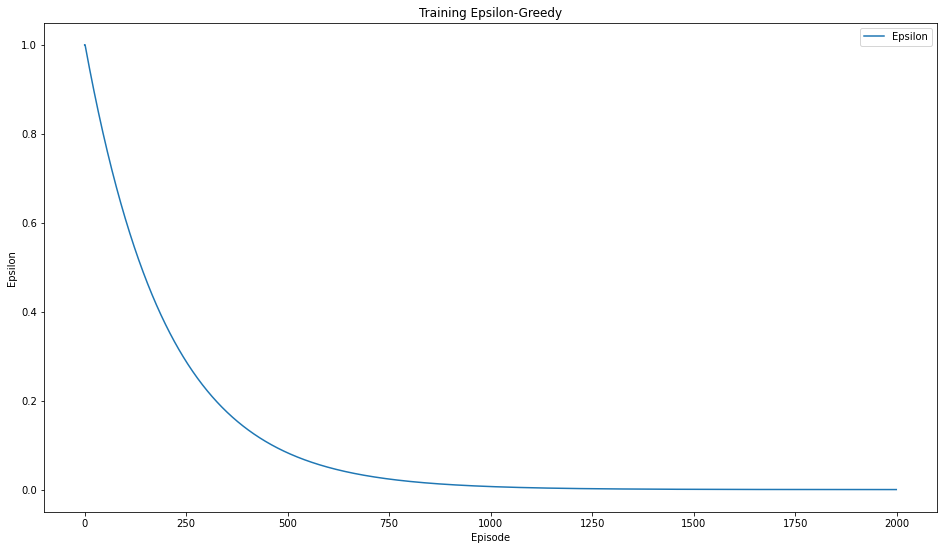

In [ ]:
# Plot Epsilon change over training. 

# This gives us an idea regarding the number of random actions taken during each episode of the training process

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))            
plt.plot(epsilon_array, label='Epsilon')

plt.ylabel('Epsilon')
plt.xlabel('Episode')
plt.title('Training Epsilon-Greedy')
plt.legend()

#plt.savefig("./CommonPlots/Rewards_Combined.svg", dpi=150)

plt.show()

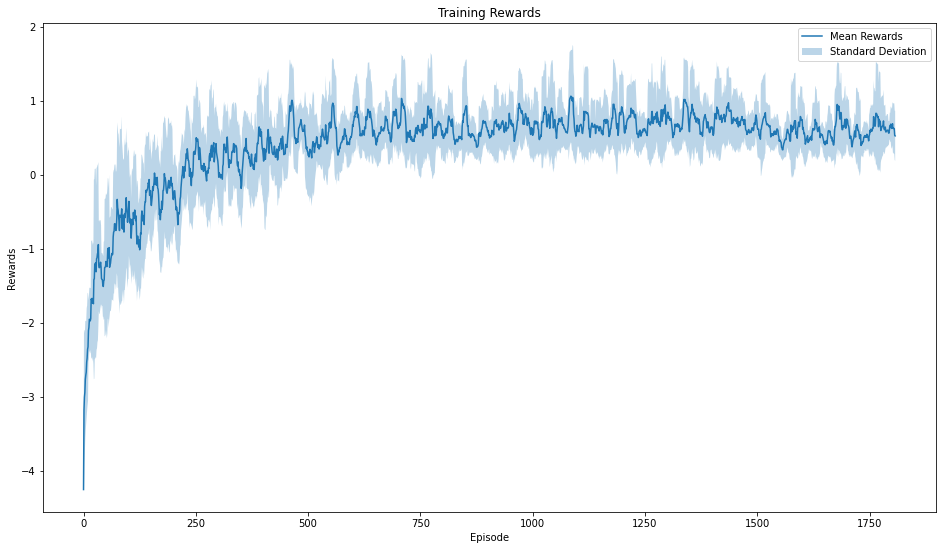

In [ ]:
# Plot average rewards over the training process

import matplotlib.pyplot as plt

resolution = 10
p = resolution

# mean_rewards = rewards_array_mean

mean_rewards = np.array([np.mean(rewards_array_mean[i-p:i+1]) 
                if i >= p else np.mean(rewards_array_mean[:i+1]) 
                for i, _ in enumerate(rewards_array_mean)])
std_rewards = np.array([np.std(rewards_array_mean[i-p:i+1])
               if i >= p else np.std(rewards_array_mean[:i+1])
               for i, _ in enumerate(rewards_array_mean)])

plt.figure(figsize=(16, 9))
plt.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)             
plt.plot(mean_rewards, label='Mean Rewards')

plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.title('Training Rewards')
plt.legend()

#plt.savefig("./CommonPlots/Rewards_Combined.svg", dpi=150)

plt.show()

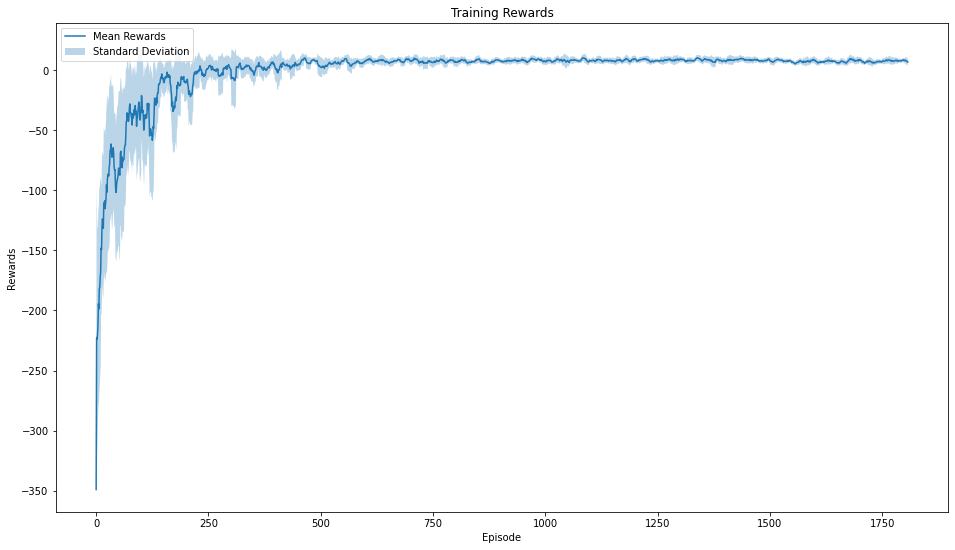

In [ ]:
# Plot sum of rewards over the training process

import matplotlib.pyplot as plt

resolution = 10
p = resolution

mean_rewards = np.array([np.mean(rewards_array_sum[i-p:i+1]) 
                if i >= p else np.mean(rewards_array_sum[:i+1]) 
                for i, _ in enumerate(rewards_array_sum)])
std_rewards = np.array([np.std(rewards_array_sum[i-p:i+1])
               if i >= p else np.std(rewards_array_sum[:i+1])
               for i, _ in enumerate(rewards_array_sum)])

plt.figure(figsize=(16, 9))
plt.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)             
plt.plot(mean_rewards, label='Mean Rewards')

plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.title('Training Rewards')
plt.legend()

#plt.savefig("./CommonPlots/Rewards_Combined.svg", dpi=150)

plt.show()

In [ ]:
# Get ready to watch our trained agent

#input("Press Enter to see our trained taxi agent")
#sleep(1)
#clear_output()  

env = gym.make('Taxi-v3')

episodes_to_preview = 3

rewards = []

for episode in range(episodes_to_preview):

	# Reset the environment
	state = env.reset()
	step = 0
	done = False
	episode_rewards = 0

	for step in range(num_steps):
		# clear screen
		clear_output(wait=True)

		print(f"TRAINED AGENT")
		print(f"+++++EPISODE {episode+1}+++++")
		print(f"Step {step+1}")

		# Exploit
		action = np.argmax(qtable[state,:])

		# Take an action and observe the reward
		new_state, reward, done, info = env.step(action)

		# Accumulate our rewards    
		episode_rewards += reward

		env.render()
		print("")
		if episode_rewards < 0:
			print(f"Score: {bcolors.RED}{episode_rewards}{bcolors.RESET}")
		else:
			print(f"Score: {bcolors.GREEN}{episode_rewards}{bcolors.RESET}")
		sleep(0.5)   
		    
		# Update to our new state
		state = new_state

		# if done, finish episode
		if done == True:
			rewards.append(episode_rewards)
			break  

# Close the Taxi environment
env.close()

TRAINED AGENT
+++++EPISODE 3+++++
Step 14

Score: 7


In [ ]:
print("rewards over testing: ",rewards)

# 👏 What's next?

There are many other environments available on OpenAI Gym for you to try (e.g. [Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/)). You can also try optimising the implementation above to solve Taxi in fewer episodes.

Some other useful resources include:
-   [DeepMind x UCL Reinforcement Learning Lecture Series [2021]](https://deepmind.com/learning-resources/reinforcement-learning-series-2021)
-   [A (Long) Peek into Reinforcement Learning](https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html) by Lilian Weng
-   [A good article on RL and its real-world applications](https://www.altexsoft.com/blog/datascience/reinforcement-learning-explained-overview-comparisons-and-applications-in-business/)
-   [AlphaGo full documentary](https://www.youtube.com/watch?v=WXuK6gekU1Y) (on Youtube)
-   [Reinforcement Learning](http://www.incompleteideas.net/book/RLbook2018trimmed.pdf) by Sutton and Barto
-   [Hands-on introduction to deep reinforcement learning](https://www.gocoder.one/blog/hands-on-introduction-to-deep-reinforcement-learning)